<a href="https://colab.research.google.com/github/jiya07/Stock-Market-Prediction-using-Numerical-and-Textual-Analysis/blob/main/Numerical_and_Textual_Analysis_of_Stock_Market_Prices_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ANIRUDH JAGANNATH

## Task 7-Numerical_and_Textual_Analysis_of_Stock_Market_Prices
Create a hybrid model for stock price/performance prediction using
numerical analysis of historical stock prices, and sentimental analysis
of news headlines

In [1]:
from google.colab import files 
uploaded = files.upload()

Saving BSESN.csv to BSESN (2).csv


In [25]:
from google.colab import files 
uploaded = files.upload()

Saving india-news-headlines.csv to india-news-headlines (1).csv


In [27]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


TIME SERIES ANALYSIS

In [3]:
df_prices = pd.read_csv('BSESN.csv')
print(df_prices.head())
print(df_prices.size)

         Date         Open         High  ...        Close    Adj Close  Volume
0  2001-01-02  3953.219971  4028.570068  ...  4018.879883  4018.879883     0.0
1  2001-01-03  3977.580078  4067.659912  ...  4060.020020  4060.020020     0.0
2  2001-01-04  4180.970215  4180.970215  ...  4115.370117  4115.370117     0.0
3  2001-01-05  4116.339844  4195.009766  ...  4183.729980  4183.729980     0.0
4  2001-01-08  4164.759766  4206.720215  ...  4120.430176  4120.430176     0.0

[5 rows x 7 columns]
34622


In [4]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946 entries, 0 to 4945
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4946 non-null   datetime64[ns]
 1   Open       4872 non-null   float64       
 2   High       4872 non-null   float64       
 3   Low        4872 non-null   float64       
 4   Close      4872 non-null   float64       
 5   Adj Close  4872 non-null   float64       
 6   Volume     4872 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 270.6 KB


In [5]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

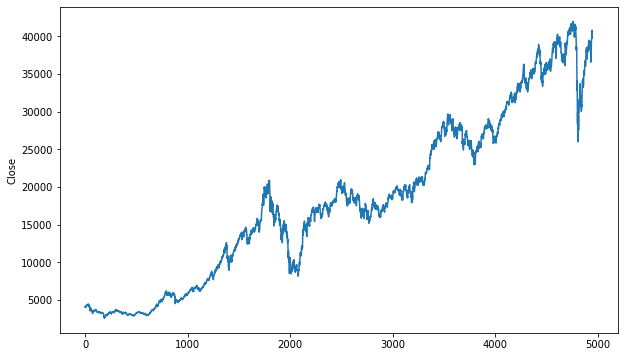

In [6]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

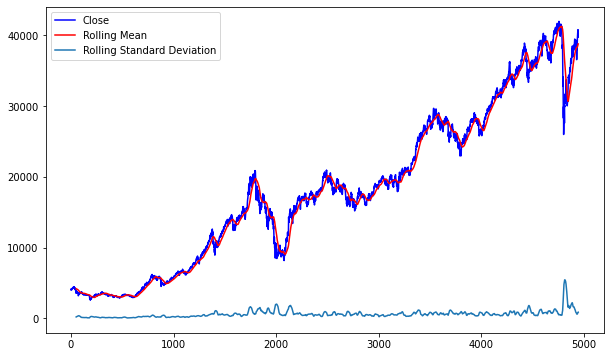

In [7]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

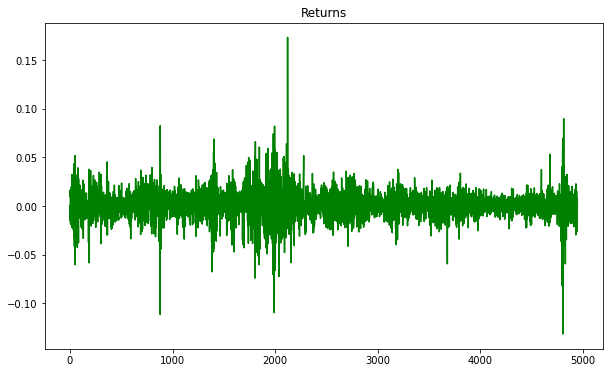

In [8]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [9]:
train = df_prices[:1000]
test = df_prices[1000:]

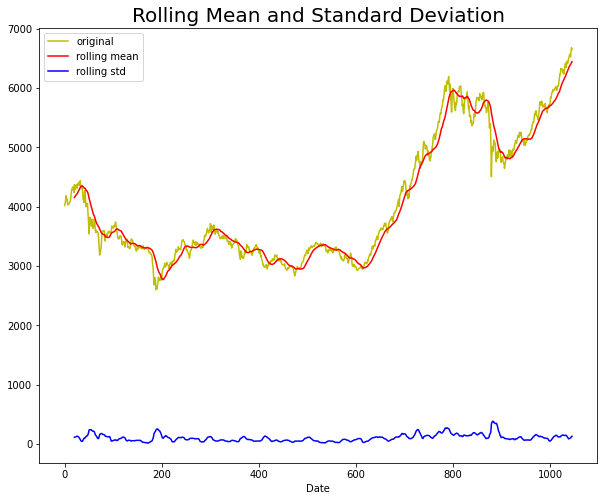

Results of dickey fuller test
ADF Test Statistic : 0.6847089129500282
p-value : 0.9895277172383614
#Lags Used : 6
Number of Observations Used : 993
Weak evidence against null hypothesis, time series is non-stationary 


In [10]:
#Stationarity test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    plt.figure(figsize = (10,8))
    plt.plot(timeseries, color = 'y', label = 'original')
    plt.plot(rolmean, color = 'r', label = 'rolling mean')
    plt.plot(rolstd, color = 'b', label = 'rolling std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
    plt.show(block = False)
 
    print('Results of dickey fuller test')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

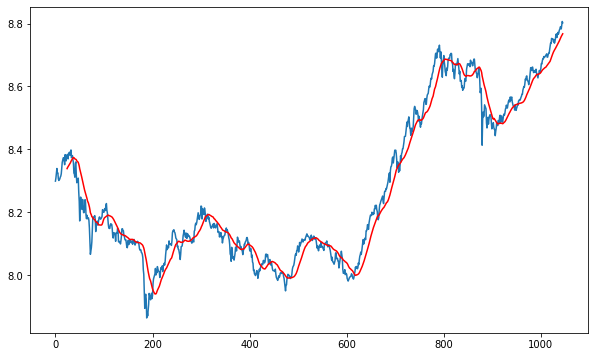

In [11]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

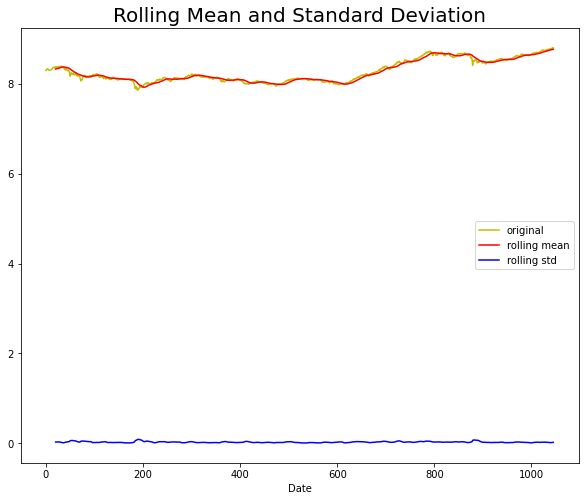

Results of dickey fuller test
ADF Test Statistic : 0.09925455869130655
p-value : 0.9660101624822954
#Lags Used : 4
Number of Observations Used : 995
Weak evidence against null hypothesis, time series is non-stationary 


In [12]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

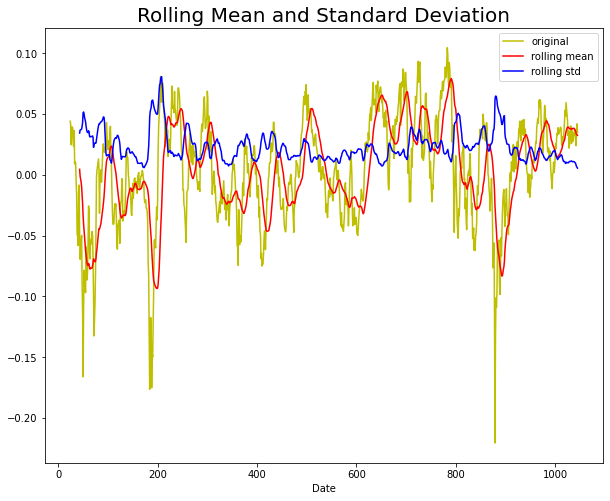

Results of dickey fuller test
ADF Test Statistic : -5.736980339921385
p-value : 6.404632148346775e-07
#Lags Used : 4
Number of Observations Used : 972
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [13]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [14]:
#conda install -c saravji pmdarima

In [16]:
#!pip install pmdarima

In [17]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.87 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-5036.986, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-5215.671, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-5365.859, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-5471.941, Time=0.23 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-5498.937, Time=0.28 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-5508.753, Time=0.48 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.46 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-5636.626, Time=2.08 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=3.34 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=inf, Time=2.91 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-5643.612, Time=1.95 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=2.32 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.7

Text(0, 0.5, 'Actual Stock Price')

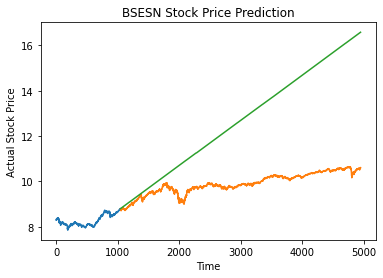

In [18]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [19]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  3.33299723811757


TEXTUAL ANALYSIS

In [30]:
import csv
cols = ['Date','Category','News']
df_news = pd.read_csv('india-news-headlines.csv',quoting=csv.QUOTE_NONE, names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010101,sports.wwe,"""win over cena satisfying but defeating undert..."
2,20010102,unknown,"""Status quo will not be disturbed at Ayodhya; ..."
3,20010102,unknown,"""Fissures in Hurriyat over Pak visit"""
4,20010102,unknown,"""America's unwanted heading for India?"""
...,...,...,...
2739428,20171118,entertainment.malayalam.movies.news,"""'Shikkari Shambu's' new poster has Salim Kuma..."
2739429,20171118,sports.badminton,"""Top-ranked Axelsen sets up China Open final a..."
2739430,20171118,tv.news.hindi,"""Kundali Bhagya written update; 17th November ..."
2739431,20171118,india,"""pm modi only world statesman to stand up to c..."


In [31]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2739432 entries, 1 to 2739432
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 62.7+ MB


In [32]:
 #Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news=df_news.head(10000)

In [33]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-01,"""win over cena satisfying but defeating undert..."
1,2001-01-02,"""Status quo will not be disturbed at Ayodhya; ..."
2,2001-01-03,"""Powerless north India gropes in the dark"" ""Th..."
3,2001-01-04,"""The string that pulled Stephen Hawking to Ind..."
4,2001-01-05,"""Light combat craft takes India into club clas..."
...,...,...
162,2001-07-23,"""BSP focuses on Punjab; UP issues for polls"" ""..."
163,2001-07-24,"""Wrong timing: Hike in fee for medical; dental..."
164,2001-07-25,"""Dataram signs up with Signet"" ""70 pc govt sta..."
165,2001-07-26,"""Karnatak varsity MA results announced"" ""How t..."


In [34]:
df_news['News']

0      "win over cena satisfying but defeating undert...
1      "Status quo will not be disturbed at Ayodhya; ...
2      "Powerless north India gropes in the dark" "Th...
3      "The string that pulled Stephen Hawking to Ind...
4      "Light combat craft takes India into club clas...
                             ...                        
162    "BSP focuses on Punjab; UP issues for polls" "...
163    "Wrong timing: Hike in fee for medical; dental...
164    "Dataram signs up with Signet" "70 pc govt sta...
165    "Karnatak varsity MA results announced" "How t...
166    "SEC gears up for local bodies election" "High...
Name: News, Length: 167, dtype: object

In [35]:
#Cleaning headlines
c = []
ps=PorterStemmer()
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [36]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...
2,2001-01-03,powerless north india grope dark think laxman ...
3,2001-01-04,string pull stephen hawk india vajpaye give bi...
4,2001-01-05,light combat craft take india club class hawk ...
...,...,...
162,2001-07-23,bsp focus punjab issu poll cong worker kill am...
163,2001-07-24,wrong time hike fee medic dental cours sebi su...
164,2001-07-25,dataram sign signet pc govt staff join stir se...
165,2001-07-26,karnatak varsiti result announc poach partner ...


In [37]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [38]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...,0.450000,0.400000
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074
2,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000
3,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481
4,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404
...,...,...,...,...
162,2001-07-23,bsp focus punjab issu poll cong worker kill am...,0.373858,-0.007289
163,2001-07-24,wrong time hike fee medic dental cours sebi su...,0.466599,0.018876
164,2001-07-25,dataram sign signet pc govt staff join stir se...,0.331401,-0.017403
165,2001-07-26,karnatak varsiti result announc poach partner ...,0.333554,-0.008239


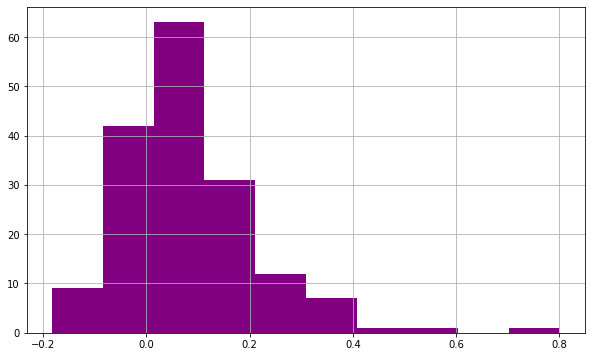

In [39]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

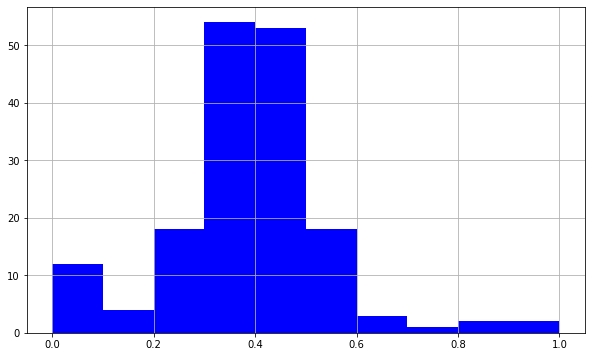

In [40]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [41]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-01,win cena satisfi defeat undertak bigger roman ...,0.450000,0.400000,0.2023,0.234,0.469,0.297
1,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
2,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
3,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
4,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
...,...,...,...,...,...,...,...,...
162,2001-07-23,bsp focus punjab issu poll cong worker kill am...,0.373858,-0.007289,-0.9967,0.139,0.790,0.071
163,2001-07-24,wrong time hike fee medic dental cours sebi su...,0.466599,0.018876,-0.9993,0.172,0.749,0.079
164,2001-07-25,dataram sign signet pc govt staff join stir se...,0.331401,-0.017403,-0.9988,0.159,0.771,0.070
165,2001-07-26,karnatak varsiti result announc poach partner ...,0.333554,-0.008239,-0.9997,0.195,0.722,0.084


In [42]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0,sangh parivar babri panel ant frontrunn key us...,0.486204,-0.035142,-0.6808,0.100,0.816,0.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2001-07-23,3340.889893,3340.889893,3310.949951,3330.979980,3330.979980,0.0,bsp focus punjab issu poll cong worker kill am...,0.373858,-0.007289,-0.9967,0.139,0.790,0.071
112,2001-07-24,3326.840088,3340.909912,3306.169922,3335.080078,3335.080078,0.0,wrong time hike fee medic dental cours sebi su...,0.466599,0.018876,-0.9993,0.172,0.749,0.079
113,2001-07-25,3307.159912,3338.219971,3296.429932,3301.969971,3301.969971,0.0,dataram sign signet pc govt staff join stir se...,0.331401,-0.017403,-0.9988,0.159,0.771,0.070
114,2001-07-26,3298.639893,3318.600098,3254.280029,3259.030029,3259.030029,0.0,karnatak varsiti result announc poach partner ...,0.333554,-0.008239,-0.9997,0.195,0.722,0.084


In [43]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,4018.879883,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,4060.020020,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,4115.370117,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,4183.729980,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,4120.430176,0.486204,-0.035142,-0.6808,0.100,0.816,0.084
...,...,...,...,...,...,...,...
111,3330.979980,0.373858,-0.007289,-0.9967,0.139,0.790,0.071
112,3335.080078,0.466599,0.018876,-0.9993,0.172,0.749,0.079
113,3301.969971,0.331401,-0.017403,-0.9988,0.159,0.771,0.070
114,3259.030029,0.333554,-0.008239,-0.9997,0.195,0.722,0.084


In [44]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.665840,0.298148,0.557192,0.072909,0.382263,0.699735,0.134921
1,0.698641,0.429167,0.410533,0.202397,0.403670,0.675926,0.149471
2,0.742772,0.475140,0.425345,0.969057,0.302752,0.723545,0.145503
3,0.797276,0.458412,0.947884,0.322833,0.522936,0.548942,0.224868
4,0.746807,0.486204,0.291458,0.161240,0.305810,0.756614,0.111111


In [45]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [46]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.298148,0.557192,0.072909,0.382263,0.699735,0.134921
1,0.429167,0.410533,0.202397,0.403670,0.675926,0.149471
2,0.475140,0.425345,0.969057,0.302752,0.723545,0.145503
3,0.458412,0.947884,0.322833,0.522936,0.548942,0.224868
4,0.486204,0.291458,0.161240,0.305810,0.756614,0.111111


In [47]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(92, 6)

In [48]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
71,0.390873,0.193688,0.032764,0.470948,0.679894,0.116402
97,0.426136,0.626521,0.607746,0.440367,0.574074,0.235450
111,0.373858,0.346604,0.001517,0.425076,0.722222,0.093915
100,0.227273,0.496028,0.505461,0.000000,1.000000,0.000000
8,0.238603,0.506202,0.993023,0.122324,0.792328,0.154762
93,0.325108,0.854580,0.998382,0.232416,0.690476,0.208995
33,0.440734,0.270752,0.815098,0.211009,0.791005,0.117725
45,0.442549,0.500399,0.965568,0.385321,0.630952,0.202381
3,0.458412,0.947884,0.322833,0.522936,0.548942,0.224868
48,0.501515,0.556311,0.864698,0.437309,0.592593,0.218254


In [49]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [50]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.34368428 0.60423421 0.70619211 0.56112905 0.41626651 0.51941332
 0.34325901 0.33648986 0.1817719  0.46511582]
10     0.914074
74     0.299788
66     0.190549
51     0.304476
7      0.672418
78     0.387484
92     0.107557
90     0.176899
107    0.197860
62     0.321507
Name: Close, dtype: float64
0.1238084046892257


In [51]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [52]:
print(mean_squared_error(predictions, y_test))

0.11377688490223829


In [53]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [54]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.21445993 0.28727815 0.89175724 0.94029727 0.86011992 0.89175724
 0.36082184 0.97473296 0.05402561 0.97473296]
10     0.914074
74     0.299788
66     0.190549
51     0.304476
7      0.672418
78     0.387484
92     0.107557
90     0.176899
107    0.197860
62     0.321507
Name: Close, dtype: float64
0.19824155460487422


In [55]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [56]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.12259136975378587


In [57]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

[11:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [58]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.14086326964741133


We observe that Xgboost model performs the best for the sentiment analysis